In [1]:
from pennylane import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sklearn.datasets import make_moons

In [2]:
from sklearn.svm import SVC

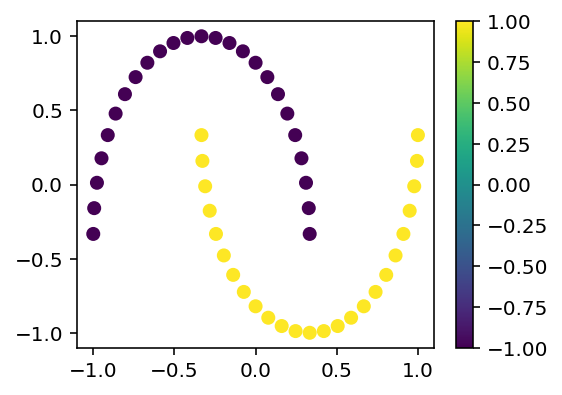

In [3]:
x, y = make_moons(n_samples=50)
y = y * 2 - 1

def normalize(x):
    """
    Переводит значения в интервал от -1 до 1
    """
    min_ = x.min()
    max_ = x.max()
    return 2 * (x - min_) / (max_ - min_) - 1

x[:, 0] = normalize(x[:, 0])
x[:, 1] = normalize(x[:, 1])

plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=y)
plt.colorbar(cb)
plt.show()

In [4]:
dev = qml.device("default.qubit", 2)

In [5]:
@qml.template
def var_layer(x):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    qml.U1(x[0], wires=0)
    qml.U1(x[1], wires=1)

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    qml.CNOT(wires=[0, 1])
    qml.U1(np.pi * np.cos(x[0]) * np.cos(x[1]), wires=1)
    qml.CNOT(wires=[0, 1])

In [6]:
@qml.qnode(dev)
def dot_prod(x1, x2):
    var_layer(x1)
    qml.inv(var_layer(x2))

    return qml.probs(wires=[0, 1])

In [7]:
def q_dot_prod(i, j):
    x1 = (x[i, 0], x[i, 1])
    x2 = (x[j, 0], x[j, 1])
    return dot_prod(x1, x2)[0]

In [8]:
print(np.allclose(q_dot_prod(0, 1), q_dot_prod(1, 0)))

True


/home/runner/work/qmlcourse/qmlcourse/.venv/lib/python3.8/site-packages/pennylane/utils.py:351: UserWarning: Use of qml.inv() is deprecated and should be replaced with qml.adjoint().
  warnings.warn(


In [9]:
print(dot_prod.draw())

 0: ──H──Rϕ(-0.667)──H──╭C────────────╭C──╭C─────────────╭C──H──Rϕ(-0.0725)──H──╭┤ Probs 
 1: ──H──Rϕ(0.821)───H──╰X──Rϕ(1.68)──╰X──╰X──Rϕ(-2.35)──╰X──H──Rϕ(-0.724)───H──╰┤ Probs 



In [10]:
gram_mat = np.zeros((x.shape[0], x.shape[0]))

for i in range(x.shape[0]):
    for j in range(x.shape[0]):
        if i == j:
            gram_mat[i, j] = 1
        if i > j:
            r = q_dot_prod(i, j)
            gram_mat[i, j] = r
            gram_mat[j, i] = r

In [11]:
model = SVC(kernel="precomputed")
model.fit(gram_mat, y)

SVC(kernel='precomputed')

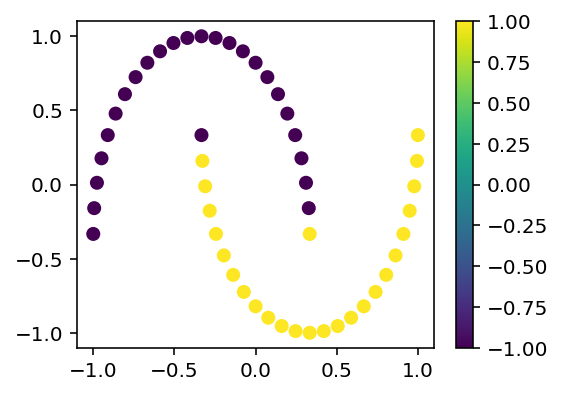

In [12]:
preds = model.predict(X=gram_mat)

plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=preds)
plt.colorbar(cb)
plt.show()